In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tempfile import mkdtemp
from shutil import rmtree
import seaborn as sns

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression,LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Loading the dataset
url = "../data/Start_up_data.csv"
data = pd.read_csv(url, encoding='latin1')
pd.set_option("display.max_columns", None)
data.head(10)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1,6/1/12,2012-06,2012-Q2,2012.0,6/30/12,6/30/12,1750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,6/4/10,9/23/10,0,4000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1,10/26/12,2012-10,2012-Q4,2012.0,8/9/12,8/9/12,40000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1,4/1/11,2011-04,2011-Q2,2011.0,4/1/11,4/1/11,1500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2,1/1/14,2014-01,2014-Q1,2014.0,8/17/14,9/26/14,0,0,60000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,"70,00,000",NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,10/10/11,2011-10,2011-Q4,2011.0,5/31/13,5/31/13,0,7000000,0,0,0,0,0,0,0,0,0,0,0,0,7000000,0,0,0,0,0,0
6,/organization/fox-networks,.Fox Networks,http://www.dotfox.com,|Advertising|,Advertising,"49,12,393",closed,ARG,NaN,Buenos Aires,Buenos Aires,1,NaN,NaN,NaN,NaN,1/16/07,1/16/07,0,0,0,4912393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,/organization/0-6-com,0-6.com,http://www.0-6.com,|Curated Web|,Curated Web,"20,00,000",operating,NaN,NaN,NaN,NaN,1,1/1/07,2007-01,2007-Q1,2007.0,3/19/08,3/19/08,0,2000000,0,0,0,0,0,0,0,0,0,0,0,2000000,0,0,0,0,0,0,0
8,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,|Software|,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,1/1/10,2010-01,2010-Q1,2010.0,7/24/14,7/24/14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,/organization/01games-technology,01Games Technology,http://www.01games.hk/,|Games|,Games,"41,250",operating,HKG,NaN,Hong Kong,Hong Kong,1,NaN,NaN,NaN,NaN,7/1/14,7/1/14,41250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.info()


In [ ]:
type(data)

In [ ]:
data.shape

In [ ]:
data.columns

In [3]:
data.columns = data.columns.str.replace(' ', '')
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace('[^a-zA-Z0-9_]', '', regex=True)
data = data.dropna(subset=['name'])
data['funding_total_usd'] = data['funding_total_usd'].str.replace(',', '')
#data['homepage_url'] = data['homepage_url'].fillna('Website not Provided')
columns_to_remove = [
    'permalink', 'state_code', 'region', 'city', 'founded_month',
    'founded_quarter', 'founded_year', 'seed', 'venture', 'equity_crowdfunding',
    'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
    'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market',
    'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E',
    'round_F', 'round_G', 'round_H'
]
data.loc[data['country_code'] != 'USA', 'country_code'] = 'Other'
data = data.drop(columns=columns_to_remove, axis=1)

In [ ]:
type(data)

In [ ]:
data.columns


In [ ]:
data['market'].nunique()

In [ ]:
data = data.iloc[:49438]

In [ ]:
data.columns

In [ ]:
#data['last_funding_at']-data['founded_at']  #total time in the market , used for operating status
#data['last_funding_at']-data['first_funding_at'] #duration of funds
#data['funding_rounds'] #no of rounds
#data['funding_total_usd'] #total funds 

In [ ]:
#X after India and Yan's changes
#y after Amruth's target encoding

In [4]:
admin_services = str('Employer Benefits Programs, Human Resource Automation, Corporate IT, Distribution, Service Providers, Archiving Service, Call Center, Collection Agency, College Recruiting, Courier Service, Debt Collections, Delivery, Document Preparation, Employee Benefits, Extermination Service, Facilities Support Services, Housekeeping Service, Human Resources, Knowledge Management, Office Administration, Packaging Services, Physical Security, Project Management, Staffing Agency, Trade Shows, Virtual Workforce').split(', ')
advertising = str('Creative Industries, Promotional, Advertising Ad Exchange, Ad Network, Ad Retargeting, Ad Server, Ad Targeting, Advertising, Advertising Platforms, Affiliate Marketing, Local Advertising, Mobile Advertising, Outdoor Advertising, SEM, Social Media Advertising, Video Advertising').split(', ')
agriculture = str('Agriculture, AgTech, Animal Feed, Aquaculture, Equestrian, Farming, Forestry, Horticulture, Hydroponics, Livestock').split(', ')
app = str('Application Performance Monitoring, App Stores, Application Platforms, Enterprise Application, App Discovery, Apps, Consumer Applications, Enterprise Applications, Mobile Apps, Reading Apps, Web Apps').split(', ')
artificial_intelli = str('Artificial Intelligence, Intelligent Systems, Machine Learning, Natural Language Processing, Predictive Analytics').split(', ')
biotechnology = str('Synthetic Biology, Bio-Pharm, Bioinformatics, Biometrics, Biopharma, Biotechnology, Genetics, Life Science, Neuroscience, Quantified Self').split(', ')
clothing = str('Fashion, Laundry and Dry-cleaning, Lingerie, Shoes').split(', ')
shopping = str('Consumer Behavior, Customer Support Tools, Discounts, Reviews and Recommendations, Auctions, Classifieds, Collectibles, Consumer Reviews, Coupons, E-Commerce, E-Commerce Platforms, Flash Sale, Gift, Gift Card, Gift Exchange, Gift Registry, Group Buying, Local Shopping, Made to Order, Marketplace, Online Auctions, Personalization, Point of Sale, Price Comparison, Rental, Retail, Retail Technology, Shopping, Shopping Mall, Social Shopping, Sporting Goods, Vending and Concessions, Virtual Goods, Wholesale').split(', ')
community = str("Self Development, Sex, Forums, Match-Making, Babies, Identity, Women, Kids, Entrepreneur, Networking, Adult, Baby, Cannabis, Children, Communities, Dating, Elderly, Family, Funerals, Humanitarian, Leisure, LGBT, Lifestyle, Men's, Online Forums, Parenting, Pet, Private Social Networking, Professional Networking, Q&A, Religion, Retirement, Sex Industry, Sex Tech, Social, Social Entrepreneurship, Teenagers, Virtual World, Wedding, Women's, Young Adults").split(', ')
electronics  = str('Mac, iPod Touch, Tablets, iPad, iPhone, Computer, Consumer Electronics, Drones, Electronics, Google Glass, Mobile Devices, Nintendo, Playstation, Roku, Smart Home, Wearables, Windows Phone, Xbox').split(', ')
consumer_goods= str('Commodities, Sunglasses, Groceries, Batteries, Cars, Beauty, Comics, Consumer Goods, Cosmetics, DIY, Drones, Eyewear, Fast-Moving Consumer Goods, Flowers, Furniture, Green Consumer Goods, Handmade, Jewelry, Lingerie, Shoes, Tobacco, Toys').split(', ')
content = str('E-Books, MicroBlogging, Opinions, Blogging Platforms, Content Delivery Network, Content Discovery, Content Syndication, Creative Agency, DRM, EBooks, Journalism, News, Photo Editing, Photo Sharing, Photography, Printing, Publishing, Social Bookmarking, Video Editing, Video Streaming').split(', ')
datagroup = str('Optimization, A/B Testing, Analytics, Application Performance Management, Artificial Intelligence, Big Data, Bioinformatics, Biometrics, Business Intelligence, Consumer Research, Data Integration, Data Mining, Data Visualization, Database, Facial Recognition, Geospatial, Image Recognition, Intelligent Systems, Location Based Services, Machine Learning, Market Research, Natural Language Processing, Predictive Analytics, Product Research, Quantified Self, Speech Recognition, Test and Measurement, Text Analytics, Usability Testing').split(', ')
design = str('Visualization, Graphics, Design, Designers, CAD, Consumer Research, Data Visualization, Fashion, Graphic Design, Human Computer Interaction, Industrial Design, Interior Design, Market Research, Mechanical Design, Product Design, Product Research, Usability Testing, UX Design, Web Design').split(', ')
education = str('Universities, College Campuses, University Students, High Schools, All Students, Colleges, Alumni, Charter Schools, College Recruiting, Continuing Education, Corporate Training, E-Learning, EdTech, Education, Edutainment, Higher Education, Language Learning, MOOC, Music Education, Personal Development, Primary Education, Secondary Education, Skill Assessment, STEM Education, Textbook, Training, Tutoring, Vocational Education').split(', ')
energy = str('Gas, Natural Gas Uses, Oil, Oil & Gas, Battery, Biofuel, Biomass Energy, Clean Energy, Electrical Distribution, Energy, Energy Efficiency, Energy Management, Energy Storage, Fossil Fuels, Fuel, Fuel Cell, Oil and Gas, Power Grid, Renewable Energy, Solar, Wind Energy').split(', ')
events = str('Concerts, Event Management, Event Promotion, Events, Nightclubs, Nightlife, Reservations, Ticketing, Wedding').split(', ')
financial = str('Debt Collecting, P2P Money Transfer, Investment Management, Trading, Accounting, Angel Investment, Asset Management, Auto Insurance, Banking, Bitcoin, Commercial Insurance, Commercial Lending, Consumer Lending, Credit, Credit Bureau, Credit Cards, Crowdfunding, Cryptocurrency, Debit Cards, Debt Collections, Finance, Financial Exchanges, Financial Services, FinTech, Fraud Detection, Funding Platform, Gift Card, Health Insurance, Hedge Funds, Impact Investing, Incubators, Insurance, InsurTech, Leasing, Lending, Life Insurance, Micro Lending, Mobile Payments, Payments, Personal Finance, Prediction Markets, Property Insurance, Real Estate Investment, Stock Exchanges, Trading Platform, Transaction Processing, Venture Capital, Virtual Currency, Wealth Management').split(', ')
food = str('Specialty Foods, Bakery, Brewing, Cannabis, Catering, Coffee, Confectionery, Cooking, Craft Beer, Dietary Supplements, Distillery, Farmers Market, Food and Beverage, Food Delivery, Food Processing, Food Trucks, Fruit, Grocery, Nutrition, Organic Food, Recipes, Restaurants, Seafood, Snack Food, Tea, Tobacco, Wine And Spirits, Winery').split(', ')
gaming = str('Game, Games, Casual Games, Console Games, Contests, Fantasy Sports, Gambling, Gamification, Gaming, MMO Games, Online Games, PC Games, Serious Games, Video Games').split(', ')
government = str('Polling, Governance, CivicTech, Government, GovTech, Law Enforcement, Military, National Security, Politics, Public Safety, Social Assistance').split(', ')
hardware= str('Cable, 3D, 3D Technology, Application Specific Integrated Circuit (ASIC), Augmented Reality, Cloud Infrastructure, Communication Hardware, Communications Infrastructure, Computer, Computer Vision, Consumer Electronics, Data Center, Data Center Automation, Data Storage, Drone Management, Drones, DSP, Electronic Design Automation (EDA), Electronics, Embedded Systems, Field-Programmable Gate Array (FPGA), Flash Storage, Google Glass, GPS, GPU, Hardware, Industrial Design, Laser, Lighting, Mechanical Design, Mobile Devices, Network Hardware, NFC, Nintendo, Optical Communication, Playstation, Private Cloud, Retail Technology, RFID, RISC, Robotics, Roku, Satellite Communication, Semiconductor, Sensor, Sex Tech, Telecommunications, Video Conferencing, Virtual Reality, Virtualization, Wearables, Windows Phone, Wireless, Xbox').split(', ')
health_care = str('Senior Health, Physicians, Electronic Health Records, Doctors, Healthcare Services, Diagnostics, Alternative Medicine, Assisted Living, Assistive Technology, Biopharma, Cannabis, Child Care, Clinical Trials, Cosmetic Surgery, Dental, Diabetes, Dietary Supplements, Elder Care, Electronic Health Record (EHR), Emergency Medicine, Employee Benefits, Fertility, First Aid, Funerals, Genetics, Health Care, Health Diagnostics, Home Health Care, Hospital, Medical, Medical Device, mHealth, Nursing and Residential Care, Nutraceutical, Nutrition, Outpatient Care, Personal Health, Pharmaceutical, Psychology, Rehabilitation, Therapeutics, Veterinary, Wellness').split(', ')
it = str('Distributors, Algorithms, ICT, M2M, Technology, Business Information Systems, CivicTech, Cloud Data Services, Cloud Management, Cloud Security, CMS, Contact Management, CRM, Cyber Security, Data Center, Data Center Automation, Data Integration, Data Mining, Data Visualization, Document Management, E-Signature, Email, GovTech, Identity Management, Information and Communications Technology (ICT), Information Services, Information Technology, Intrusion Detection, IT Infrastructure, IT Management, Management Information Systems, Messaging, Military, Network Security, Penetration Testing, Private Cloud, Reputation, Sales Automation, Scheduling, Social CRM, Spam Filtering, Technical Support, Unified Communications, Video Chat, Video Conferencing, Virtualization, VoIP').split(', ')
internet = str('Online Identity, Cyber, Portals, Web Presence Management, Domains, Tracking, Web Tools, Curated Web, Search, Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud Management, Cloud Storage, Darknet, Domain Registrar, E-Commerce Platforms, Ediscovery, Email, Internet, Internet of Things, ISP, Location Based Services, Messaging, Music Streaming, Online Forums, Online Portals, Private Cloud, Product Search, Search Engine, SEM, Semantic Search, Semantic Web, SEO, SMS, Social Media, Social Media Management, Social Network, Unified Communications, Vertical Search, Video Chat, Video Conferencing, Visual Search, VoIP, Web Browsers, Web Hosting').split(', ')
invest = str('Angel Investment, Banking, Commercial Lending, Consumer Lending, Credit, Credit Cards, Financial Exchanges, Funding Platform, Hedge Funds, Impact Investing, Incubators, Micro Lending, Stock Exchanges, Trading Platform, Venture Capital').split(', ')
manufacturing = str('Innovation Engineering, Civil Engineers, Heavy Industry, Engineering Firms, Systems, 3D Printing, Advanced Materials, Foundries, Industrial, Industrial Automation, Industrial Engineering, Industrial Manufacturing, Machinery Manufacturing, Manufacturing, Paper Manufacturing, Plastics and Rubber Manufacturing, Textiles, Wood Processing').split(', ')
media = str('Writers, Creative, Television, Entertainment, Media, Advice, Animation, Art, Audio, Audiobooks, Blogging Platforms, Broadcasting, Celebrity, Concerts, Content, Content Creators, Content Discovery, Content Syndication, Creative Agency, Digital Entertainment, Digital Media, DRM, EBooks, Edutainment, Event Management, Event Promotion, Events, Film, Film Distribution, Film Production, Guides, In-Flight Entertainment, Independent Music, Internet Radio, Journalism, Media and Entertainment, Motion Capture, Music, Music Education, Music Label, Music Streaming, Music Venues, Musical Instruments, News, Nightclubs, Nightlife, Performing Arts, Photo Editing, Photo Sharing, Photography, Podcast, Printing, Publishing, Reservations, Social Media, Social News, Theatre, Ticketing, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming, Virtual World').split(', ')
message = str('Unifed Communications, Chat, Email, Meeting Software, Messaging, SMS, Unified Communications, Video Chat, Video Conferencing, VoIP, Wired Telecommunications').split(', ')
mobile = str('Android, Google Glass, iOS, mHealth, Mobile, Mobile Apps, Mobile Devices, Mobile Payments, Windows Phone, Wireless').split(', ')
music = str('Audio, Audiobooks, Independent Music, Internet Radio, Music, Music Education, Music Label, Music Streaming, Musical Instruments, Podcast').split(', ')
resource = str('Biofuel, Biomass Energy, Fossil Fuels, Mineral, Mining, Mining Technology, Natural Resources, Oil and Gas, Precious Metals, Solar, Timber, Water, Wind Energy').split(', ')
navigation = str('Maps, Geospatial, GPS, Indoor Positioning, Location Based Services, Mapping Services, Navigation').split(', ')
other = str('Mass Customization, Monetization, Testing, Subscription Businesses, Mobility, Incentives, Peer-to-Peer, Nonprofits, Alumni, Association, B2B, B2C, Blockchain, Charity, Collaboration, Collaborative Consumption, Commercial, Consumer, Crowdsourcing, Customer Service, Desktop Apps, Emerging Markets, Enterprise, Ethereum, Franchise, Freemium, Generation Y, Generation Z, Homeless Shelter, Infrastructure, Knowledge Management, LGBT Millennials, Non Profit, Peer to Peer, Professional Services, Project Management, Real Time, Retirement, Service Industry, Sharing Economy, Small and Medium Businesses, Social Bookmarking, Social Impact, Subscription Service, Technical Support, Underserved Children, Universities').split(', ')
payment = str('Billing, Bitcoin, Credit Cards, Cryptocurrency, Debit Cards, Fraud Detection, Mobile Payments, Payments, Transaction Processing, Virtual Currency').split(', ')
platforms = str('Development Platforms, Android, Facebook, Google, Google Glass, iOS, Linux, macOS, Nintendo, Operating Systems, Playstation, Roku, Tizen, Twitter, WebOS, Windows, Windows Phone, Xbox').split(', ')
privacy = str('Digital Rights Management, Personal Data, Cloud Security, Corrections Facilities, Cyber Security, DRM, E-Signature, Fraud Detection, Homeland Security, Identity Management, Intrusion Detection, Law Enforcement, Network Security, Penetration Testing, Physical Security, Privacy, Security').split(', ')
services = str('Funeral Industry, English-Speaking, Spas, Plumbers, Service Industries, Staffing Firms, Translation, Career Management, Business Services, Services, Accounting, Business Development, Career Planning, Compliance, Consulting, Customer Service, Employment, Environmental Consulting, Field Support, Freelance, Intellectual Property, Innovation Management, Legal, Legal Tech, Management Consulting, Outsourcing, Professional Networking, Quality Assurance, Recruiting, Risk Management, Social Recruiting, Translation Service').split(', ')
realestate= str('Office Space, Self Storage, Brokers, Storage, Home Owners, Self Storage , Realtors, Home & Garden, Utilities, Home Automation, Architecture, Building Maintenance, Building Material, Commercial Real Estate, Construction, Coworking, Facility Management, Fast-Moving Consumer Goods, Green Building, Home and Garden, Home Decor, Home Improvement, Home Renovation, Home Services, Interior Design, Janitorial Service, Landscaping, Property Development, Property Management, Real Estate, Real Estate Investment, Rental Property, Residential, Self-Storage, Smart Building, Smart Cities, Smart Home, Timeshare, Vacation Rental').split(', ')
sales = str('Advertising, Affiliate Marketing, App Discovery, App Marketing, Brand Marketing, Cause Marketing, Content Marketing, CRM, Digital Marketing, Digital Signage, Direct Marketing, Direct Sales, Email Marketing, Lead Generation, Lead Management, Local, Local Advertising, Local Business, Loyalty Programs, Marketing, Marketing Automation, Mobile Advertising, Multi-level Marketing, Outdoor Advertising, Personal Branding, Public Relations, Sales, Sales Automation, SEM, SEO, Social CRM, Social Media Advertising, Social Media Management, Social Media Marketing, Sponsorship, Video Advertising').split(', ')
science = str('Face Recognition, New Technologies, Advanced Materials, Aerospace, Artificial Intelligence, Bioinformatics, Biometrics, Biopharma, Biotechnology, Chemical, Chemical Engineering, Civil Engineering, Embedded Systems, Environmental Engineering, Human Computer Interaction, Industrial Automation, Industrial Engineering, Intelligent Systems, Laser, Life Science, Marine Technology, Mechanical Engineering, Nanotechnology, Neuroscience, Nuclear, Quantum Computing, Robotics, Semiconductor, Software Engineering, STEM Education').split(', ')
software = str('Business Productivity, 3D Technology, Android, App Discovery, Application Performance Management, Apps, Artificial Intelligence, Augmented Reality, Billing, Bitcoin, Browser Extensions, CAD, Cloud Computing, Cloud Management, CMS, Computer Vision, Consumer Applications, Consumer Software, Contact Management, CRM, Cryptocurrency, Data Center Automation, Data Integration, Data Storage, Data Visualization, Database, Developer APIs, Developer Platform, Developer Tools, Document Management, Drone Management, E-Learning, EdTech, Electronic Design Automation (EDA), Embedded Software, Embedded Systems, Enterprise Applications, Enterprise Resource Planning (ERP), Enterprise Software, Facial Recognition, File Sharing, IaaS, Image Recognition, iOS, Linux, Machine Learning, macOS, Marketing Automation, Meeting Software, Mobile Apps, Mobile Payments, MOOC, Natural Language Processing, Open Source, Operating Systems, PaaS, Predictive Analytics, Presentation Software, Presentations, Private Cloud, Productivity Tools, QR Codes, Reading Apps, Retail Technology, Robotics, SaaS, Sales Automation, Scheduling, Sex Tech, Simulation, SNS, Social CRM, Software, Software Engineering, Speech Recognition, Task Management, Text Analytics, Transaction Processing, Video Conferencing, Virtual Assistant, Virtual Currency, Virtual Desktop, Virtual Goods, Virtual Reality, Virtual World, Virtualization, Web Apps, Web Browsers, Web Development').split(', ')
sports = str('American Football, Baseball, Basketball, Boating, Cricket, Cycling, Diving, eSports, Fantasy Sports, Fitness, Golf, Hockey, Hunting, Outdoors, Racing, Recreation, Rugby, Sailing, Skiing, Soccer, Sporting Goods, Sports, Surfing, Swimming, Table Tennis, Tennis, Ultimate Frisbee, Volley Ball').split(', ')
sustainability = str('Green, Wind, Biomass Power Generation, Renewable Tech, Environmental Innovation, Renewable Energies, Clean Technology, Biofuel, Biomass Energy, Clean Energy, CleanTech, Energy Efficiency, Environmental Engineering, Green Building, Green Consumer Goods, GreenTech, Natural Resources, Organic, Pollution Control, Recycling, Renewable Energy, Solar, Sustainability, Waste Management, Water Purification, Wind Energy').split(', ')
transportation = str('Taxis, Air Transportation, Automotive, Autonomous Vehicles, Car Sharing, Courier Service, Delivery Service, Electric Vehicle, Ferry Service, Fleet Management, Food Delivery, Freight Service, Last Mile Transportation, Limousine Service, Logistics, Marine Transportation, Parking, Ports and Harbors, Procurement, Public Transportation, Railroad, Recreational Vehicles, Ride Sharing, Same Day Delivery, Shipping, Shipping Broker, Space Travel, Supply Chain Management, Taxi Service, Transportation, Warehousing, Water Transportation').split(', ')
travel = str('Adventure Travel, Amusement Park and Arcade, Business Travel, Casino, Hospitality, Hotel, Museums and Historical Sites, Parks, Resorts, Timeshare, Tour Operator, Tourism, Travel, Travel Accommodations, Travel Agency, Vacation Rental').split(', ')
video = str('Animation, Broadcasting, Film, Film Distribution, Film Production, Motion Capture, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming').split(', ')

In [5]:
import re 
data['Industry_Group'] = pd.np.where(data.market.str.contains('|'.join(admin_services), flags=re.IGNORECASE), "Administrative Services",
                               pd.np.where(data.market.str.contains('|'.join(software), flags=re.IGNORECASE), "Software", 
                               pd.np.where(data.market.str.contains('|'.join(advertising), flags=re.IGNORECASE), "Advertising",
                               pd.np.where(data.market.str.contains('|'.join(agriculture), flags=re.IGNORECASE), "Agriculture and Farming",
                               pd.np.where(data.market.str.contains('|'.join(app), flags=re.IGNORECASE), "Apps", 
                               pd.np.where(data.market.str.contains('|'.join(artificial_intelli), flags=re.IGNORECASE), "Artificial Intelligence", 
                               pd.np.where(data.market.str.contains('|'.join(biotechnology), flags=re.IGNORECASE), "Biotechnology", 
                               pd.np.where(data.market.str.contains('|'.join(clothing), flags=re.IGNORECASE), "Clothing and Apparel", 
                               pd.np.where(data.market.str.contains('|'.join(shopping), flags=re.IGNORECASE), "Commerce and Shopping", 
                               pd.np.where(data.market.str.contains('|'.join(community), flags=re.IGNORECASE), "Community and Lifestyle", 
                               pd.np.where(data.market.str.contains('|'.join(electronics), flags=re.IGNORECASE), "Consumer Electronics", 
                               pd.np.where(data.market.str.contains('|'.join(consumer_goods), flags=re.IGNORECASE), "Consumer Goods", 
                               pd.np.where(data.market.str.contains('|'.join(content), flags=re.IGNORECASE), "Content and Publishing", 
                               pd.np.where(data.market.str.contains('|'.join(data), flags=re.IGNORECASE), "Data and Analytics",
                               pd.np.where(data.market.str.contains('|'.join(design), flags=re.IGNORECASE), "Design", 
                               pd.np.where(data.market.str.contains('|'.join(education), flags=re.IGNORECASE), "Education", 
                               pd.np.where(data.market.str.contains('|'.join(energy), flags=re.IGNORECASE), "Energy", 
                               pd.np.where(data.market.str.contains('|'.join(events), flags=re.IGNORECASE), "Events", 
                               pd.np.where(data.market.str.contains('|'.join(financial), flags=re.IGNORECASE), "Financial Services",
                               pd.np.where(data.market.str.contains('|'.join(food), flags=re.IGNORECASE), "Food and Beverage", 
                               pd.np.where(data.market.str.contains('|'.join(gaming), flags=re.IGNORECASE), "Gaming", 
                               pd.np.where(data.market.str.contains('|'.join(government), flags=re.IGNORECASE), "Government and Military", 
                               pd.np.where(data.market.str.contains('|'.join(hardware), flags=re.IGNORECASE), "Hardware",
                               pd.np.where(data.market.str.contains('|'.join(health_care), flags=re.IGNORECASE), "Health Care",
                               pd.np.where(data.market.str.contains('|'.join(it), flags=re.IGNORECASE), "Information Technology", 
                               pd.np.where(data.market.str.contains('|'.join(internet), flags=re.IGNORECASE), "Internet Services", 
                               pd.np.where(data.market.str.contains('|'.join(invest), flags=re.IGNORECASE), "Lending and Investments", 
                               pd.np.where(data.market.str.contains('|'.join(manufacturing), flags=re.IGNORECASE), "Manufacturing",
                               pd.np.where(data.market.str.contains('|'.join(media), flags=re.IGNORECASE), "Media and Entertainment",
                               pd.np.where(data.market.str.contains('|'.join(message), flags=re.IGNORECASE), "Messaging and Telecommunication", 
                               pd.np.where(data.market.str.contains('|'.join(mobile), flags=re.IGNORECASE), "Mobile", 
                               pd.np.where(data.market.str.contains('|'.join(music), flags=re.IGNORECASE), "Music and Audio", 
                               pd.np.where(data.market.str.contains('|'.join(resource), flags=re.IGNORECASE), "Natural Resources",
                               pd.np.where(data.market.str.contains('|'.join(navigation), flags=re.IGNORECASE), "Navigation and Mapping",
                               pd.np.where(data.market.str.contains('|'.join(payment), flags=re.IGNORECASE), "Payments", 
                               pd.np.where(data.market.str.contains('|'.join(platforms), flags=re.IGNORECASE), "Platforms", 
                               pd.np.where(data.market.str.contains('|'.join(privacy), flags=re.IGNORECASE), "Privacy and Security", 
                               pd.np.where(data.market.str.contains('|'.join(services), flags=re.IGNORECASE), "Professional Services",
                               pd.np.where(data.market.str.contains('|'.join(realestate), flags=re.IGNORECASE), "Real Estate", 
                               pd.np.where(data.market.str.contains('|'.join(sales), flags=re.IGNORECASE), "Sales and Marketing", 
                               pd.np.where(data.market.str.contains('|'.join(science), flags=re.IGNORECASE), "Science and Engineering", 
                               pd.np.where(data.market.str.contains('|'.join(sports), flags=re.IGNORECASE), "Sports",
                               pd.np.where(data.market.str.contains('|'.join(sustainability), flags=re.IGNORECASE), "Sustainability", 
                               pd.np.where(data.market.str.contains('|'.join(transportation), flags=re.IGNORECASE), "Transportation", 
                               pd.np.where(data.market.str.contains('|'.join(travel), flags=re.IGNORECASE), "Travel and Tourism", 
                               pd.np.where(data.market.str.contains('|'.join(video), flags=re.IGNORECASE), "Video",
                               pd.np.where(data.market.str.contains('|'.join(other), flags=re.IGNORECASE), "Other",  "Other")))))))))))))))))))))))))))))))))))))))))))))))

/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data['Industry_Group'] = pd.np.where(data.market.str.contains('|'.join(admin_services), flags=re.IGNORECASE), "Administrative Services",
/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(data.market.str.contains('|'.join(software), flags=re.IGNORECASE), "Software",
/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pd.np.where(data.market.str.contains('|'.join(software), flags=re.IGNORECASE), "Software",
/var/folders/mg/t_snxgx14kn6

/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:27: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(data.market.str.contains('|'.join(internet), flags=re.IGNORECASE), "Internet Services",
/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:28: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(data.market.str.contains('|'.join(invest), flags=re.IGNORECASE), "Lending and Investments",
/var/folders/mg/t_snxgx14kn6k6h_qb8yn_hc0000gn/T/ipykernel_18304/3623873125.py:29: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.where(data.market.str.contains('|'.join(manufacturing), flags=re.IGNORECASE), "Manufacturing",
/var/folders/mg/t_snxgx14kn6k6h_qb8yn_

In [ ]:
data.head(5)

In [6]:
data_1 = data

In [7]:
data_1 = data_1.drop('market', axis = 1)

In [35]:
data_1 = data_1.drop('category_list', axis = 1)

In [ ]:
data_1.head(5)

In [36]:
data_1['time_between_first_last_funding'] = (pd.to_datetime(data_1['last_funding_at'], format='%m/%d/%y', errors="coerce") - pd.to_datetime(data_1['first_funding_at'], errors="coerce")).dt.days

KeyError: 'last_funding_at'

In [ ]:
data_1.head(5)

In [9]:
data_1 = data_1[data_1['funding_total_usd'] != ' -   ']
data_1 = data_1.reset_index(drop=True)
data_1 = data_1.drop_duplicates(subset=['name', 'homepage_url', 'Industry_Group'])

In [10]:
# YOUR CODE HERE
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# Build the pipeline with the different steps

In [ ]:
#data_1 = data_1.drop(columns=['status'])
#y = data['status']

In [37]:
data_1.head()

,funding_total_usd,status,country_code,funding_rounds,Industry_Group,time_between_first_last_funding
0,1750000,0.0,USA,1,Content and Publishing,0.0
1,4000000,2.0,USA,2,Gaming,111.0
2,40000,2.0,Other,1,Content and Publishing,0.0
3,1500000,2.0,Other,1,Consumer Electronics,0.0
4,60000,2.0,USA,2,Travel and Tourism,40.0


In [11]:
data_1 = data_1.drop(columns=['homepage_url'])

In [12]:
num_missing = data_1['time_between_first_last_funding'].isna().sum()
num_missing

2

In [ ]:
# Get the rows where the 'column_name' column is NaN
nan_rows = data_1[data_1['time_between_first_last_funding'].isna()]
nan_rows

In [38]:
data_1.dropna(subset=['time_between_first_last_funding'], inplace=True)

In [39]:
num_missing = data_1['time_between_first_last_funding'].isna().sum()
num_missing

0

In [ ]:
#num_missing = data_1['existence_between_founded_at_last_funding_at'].isna().sum()
#num_missing

In [ ]:
data_1.head(2)

In [40]:
# YOUR CODE HERE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_1.dtypes.value_counts()

int64      2
float64    2
object     2
dtype: int64

In [41]:
# Convert the 'column_name' column from object to integer
data_1['funding_total_usd'] = data_1['funding_total_usd'].astype(int)

In [42]:
data_1 = data_1.drop(columns=['name'])


KeyError: "['name'] not found in axis"

In [43]:
data_1 = data_1.drop(columns=['founded_at'])
data_1 = data_1.drop(columns=['first_funding_at'])
data_1 = data_1.drop(columns=['last_funding_at'])

KeyError: "['founded_at'] not found in axis"

In [44]:
feat_categorical_nunique = data_1.drop('status', axis=1).select_dtypes(include='object').nunique()
feat_categorical_nunique

country_code       2
Industry_Group    43
dtype: int64

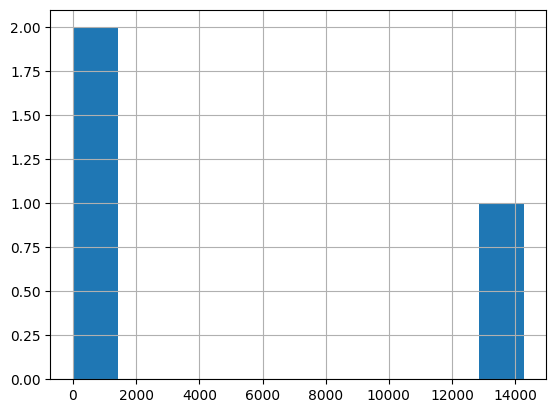

In [20]:
feat_categorical_nunique.hist();

In [ ]:
#feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)
#feat_categorical_small

In [45]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, ['country_code']),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28bc02350>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['country_code'])])

In [46]:
data_1.dropna(subset=['status'], inplace=True)

In [47]:
from sklearn.preprocessing import OrdinalEncoder

# Instantiate a OrdinalEncoding for the categorical feature status
oe = OrdinalEncoder()

# Fitting it
oe.fit(data_1[['status']])

# Showing the categories detected by the encoder
display(oe.categories_) 

# Since Sklearn 1.1, we can retrieve the names of the generated columns
display(oe.get_feature_names_out()) 

# Let's encode status
status_encoded = oe.transform(data_1[['status']])
                         
# Now we store the encoded values in the dataframe    
data_1[oe.get_feature_names_out()] = status_encoded

# We can get rid of the original column EngineType now
#data_1.drop(columns='status', inplace = True)

[array([0., 1., 2.])]

array(['status'], dtype=object)

In [ ]:
data_1.head(2)

In [48]:
data_baseline = data_1.drop('Industry_Group',axis = 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_baseline.drop(['status'], axis=1), data_baseline['status'], test_size=0.3, random_state=42)

In [50]:
pipe_baseline = make_pipeline(preproc_baseline, LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000))
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28bc02350>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_code'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [51]:
X_train, y_train



# Fit the model to the data
pipe_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28bc02350>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_code'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [52]:
#preproc_baseline.fit_transform(X)
pipe_baseline.score(X_test, y_test)

0.8656616415410385

In [ ]:
preproc_baseline

In [53]:
# OPTION 2 - re-use Sklearn's "mean_squared_log_error"

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)



In [30]:
X_train.head(2)

,category_list,funding_total_usd,country_code,funding_rounds,time_between_first_last_funding
32174,|Hardware + Software|,785000,USA,2,238.0
18237,|Analytics|,2015000,USA,2,608.0


In [54]:
score_baseline = cross_val_score(pipe_baseline, X_train, y_train, cv=5, scoring=rmsle).mean()
score_baseline

0.32463726418328376

Our baseline model is ready

In [ ]:
#######

In [ ]:
#######

In [ ]:
data_1.head(2)

In [71]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore",sparse=False)
)

preproc_baseline_2_with_industry = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, ['country_code','Industry_Group']),
    remainder="drop"
)

preproc_baseline_2_with_industry

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28bc02f80>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['country_code', 'Industry_Group'])])

In [67]:
data_2 = data_1
data_2.head(2)

,funding_total_usd,status,country_code,funding_rounds,Industry_Group,time_between_first_last_funding
0,1750000,0.0,USA,1,Content and Publishing,0.0
1,4000000,2.0,USA,2,Gaming,111.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(data_2.drop(['status'], axis=1), data_2['status'], test_size=0.3, random_state=42)

In [138]:
pd.DataFrame(preproc_baseline_2_with_industry.fit_transform(X_train))

/Users/deepatamraparani/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.000138,0.058824,0.664937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000354,0.058824,0.677569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000923,0.058824,0.680608,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000219,0.000000,0.656811,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000287,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27853,0.000005,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27854,0.000368,0.058824,0.742677,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27855,0.000007,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27856,0.000386,0.058824,0.679140,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
X_train_scaled

array([[1.37719123e-04, 5.88235294e-02, 6.64936839e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.53508597e-04, 5.88235294e-02, 6.77569136e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.22834912e-04, 5.88235294e-02, 6.80607716e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.01736842e-06, 0.00000000e+00, 6.56811198e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.85964737e-04, 5.88235294e-02, 6.79139638e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.19280702e-06, 0.00000000e+00, 6.56811198e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [102]:
# Get the transformed column names
new_col_names1 = preproc_baseline_2_with_industry.named_transformers_['pipeline-1'][0].get_feature_names_out()
#named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(['country_code','Industry_Group'])
list(new_col_names1)

['funding_total_usd', 'funding_rounds', 'time_between_first_last_funding']

In [97]:
X_train_scaled.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.000138,0.058824,0.664937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000354,0.058824,0.677569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
# Create a new DataFrame with the transformed data and column names
pd.DataFrame(preproc_baseline_2_with_industry.fit_transform(X_train,y_train), columns=list(new_col_names1)+ list(new_col_names2))

/Users/deepatamraparani/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,funding_total_usd,funding_rounds,time_between_first_last_funding,country_code_Other,country_code_USA,Industry_Group_Administrative Services,Industry_Group_Advertising,Industry_Group_Agriculture and Farming,Industry_Group_Apps,Industry_Group_Artificial Intelligence,Industry_Group_Biotechnology,Industry_Group_Clothing and Apparel,Industry_Group_Commerce and Shopping,Industry_Group_Community and Lifestyle,Industry_Group_Consumer Electronics,Industry_Group_Consumer Goods,Industry_Group_Content and Publishing,Industry_Group_Data and Analytics,Industry_Group_Design,Industry_Group_Education,Industry_Group_Energy,Industry_Group_Events,Industry_Group_Financial Services,Industry_Group_Food and Beverage,Industry_Group_Gaming,Industry_Group_Government and Military,Industry_Group_Hardware,Industry_Group_Health Care,Industry_Group_Information Technology,Industry_Group_Internet Services,Industry_Group_Manufacturing,Industry_Group_Media and Entertainment,Industry_Group_Messaging and Telecommunication,Industry_Group_Mobile,Industry_Group_Natural Resources,Industry_Group_Navigation and Mapping,Industry_Group_Other,Industry_Group_Platforms,Industry_Group_Privacy and Security,Industry_Group_Professional Services,Industry_Group_Real Estate,Industry_Group_Sales and Marketing,Industry_Group_Science and Engineering,Industry_Group_Software,Industry_Group_Sports,Industry_Group_Sustainability,Industry_Group_Transportation,Industry_Group_Travel and Tourism
0,0.000138,0.058824,0.664937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000354,0.058824,0.677569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000923,0.058824,0.680608,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000219,0.000000,0.656811,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000287,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27853,0.000005,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27854,0.000368,0.058824,0.742677,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27855,0.000007,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27856,0.000386,0.058824,0.679140,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pipe_baseline

In [108]:
X_train_transformed.head(5)

,funding_total_usd,funding_rounds,time_between_first_last_funding,country_code_Other,country_code_USA,Industry_Group_Administrative Services,Industry_Group_Advertising,Industry_Group_Agriculture and Farming,Industry_Group_Apps,Industry_Group_Artificial Intelligence,Industry_Group_Biotechnology,Industry_Group_Clothing and Apparel,Industry_Group_Commerce and Shopping,Industry_Group_Community and Lifestyle,Industry_Group_Consumer Electronics,Industry_Group_Consumer Goods,Industry_Group_Content and Publishing,Industry_Group_Data and Analytics,Industry_Group_Design,Industry_Group_Education,Industry_Group_Energy,Industry_Group_Events,Industry_Group_Financial Services,Industry_Group_Food and Beverage,Industry_Group_Gaming,Industry_Group_Government and Military,Industry_Group_Hardware,Industry_Group_Health Care,Industry_Group_Information Technology,Industry_Group_Internet Services,Industry_Group_Manufacturing,Industry_Group_Media and Entertainment,Industry_Group_Messaging and Telecommunication,Industry_Group_Mobile,Industry_Group_Natural Resources,Industry_Group_Navigation and Mapping,Industry_Group_Other,Industry_Group_Platforms,Industry_Group_Privacy and Security,Industry_Group_Professional Services,Industry_Group_Real Estate,Industry_Group_Sales and Marketing,Industry_Group_Science and Engineering,Industry_Group_Software,Industry_Group_Sports,Industry_Group_Sustainability,Industry_Group_Transportation,Industry_Group_Travel and Tourism
0,0.000138,0.058824,0.664937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.000354,0.058824,0.677569,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000923,0.058824,0.680608,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000219,0.000000,0.656811,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000287,0.000000,0.656811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
preproc_baseline_2_with_industry

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28bc02f80>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['country_code', 'Industry_Group'])])

In [142]:
#data_2 = data_1.drop('Industry_Group',axis = 1)
#Use Industry Group

#X_train, X_test, y_train, y_test = train_test_split(data_2.drop(['status'], axis=1), data_2['status'], test_size=0.3, random_state=42)

pipe_baseline = make_pipeline(preproc_baseline_2_with_industry, LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
pipe_baseline


# Fit the model to the data
pipe_baseline.fit(X_train, y_train)

#preproc_baseline.fit_transform(X)





# OPTION 2 - re-use Sklearn's "mean_squared_log_error"

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)


score_baseline = cross_val_score(pipe_baseline, X_train, y_train, cv=5, scoring=rmsle).mean()
score_baseline

/Users/deepatamraparani/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/deepatamraparani/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/deepatamraparani/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/deepatamraparani/.pyenv/versions/3.1

0.32463726418328376

In [122]:
X_train

,funding_total_usd,country_code,funding_rounds,Industry_Group,time_between_first_last_funding
32174,785000,USA,2,Software,238.0
18237,2015000,USA,2,Other,608.0
21740,5260160,Other,2,Commerce and Shopping,697.0
13579,1250000,USA,1,Financial Services,0.0
16982,1637554,Other,1,Other,0.0
...,...,...,...,...,...
6441,27181,Other,1,Real Estate,0.0
11597,2100000,USA,2,Software,2515.0
39236,40000,Other,1,Internet Services,0.0
878,2200000,Other,2,Advertising,654.0


In [131]:
y_train.head()

32174    2.0
18237    2.0
21740    2.0
13579    1.0
16982    2.0
Name: status, dtype: float64

In [151]:
from sklearn.inspection import permutation_importance

permutation_score = permutation_importance(pipe_baseline, X_train, y_train, n_repeats=100) # Perform Permutation
permutation_score

{'importances_mean': array([4.88190107e-05, 1.50764592e-05, 0.00000000e+00, 3.26656616e-05,
        3.58963314e-07]),
 'importances_std': array([2.18466854e-05, 1.77169397e-05, 0.00000000e+00, 2.59324599e-05,
        3.57163988e-06]),
 'importances': array([[3.58963314e-05, 3.58963314e-05, 7.17926628e-05, 3.58963314e-05,
         7.17926628e-05, 0.00000000e+00, 3.58963314e-05, 3.58963314e-05,
         7.17926628e-05, 1.07688994e-04, 7.17926628e-05, 7.17926628e-05,
         3.58963314e-05, 3.58963314e-05, 7.17926628e-05, 3.58963314e-05,
         3.58963314e-05, 7.17926628e-05, 3.58963314e-05, 3.58963314e-05,
         3.58963314e-05, 3.58963314e-05, 3.58963314e-05, 7.17926628e-05,
         3.58963314e-05, 3.58963314e-05, 3.58963314e-05, 7.17926628e-05,
         7.17926628e-05, 3.58963314e-05, 3.58963314e-05, 3.58963314e-05,
         7.17926628e-05, 3.58963314e-05, 3.58963314e-05, 7.17926628e-05,
         3.58963314e-05, 3.58963314e-05, 3.58963314e-05, 0.00000000e+00,
         1.07688994e

In [152]:
importance_df = pd.DataFrame(np.vstack((pipe_baseline,
                                        permutation_score.importances_mean)).T, # Unstack results
                            columns = ['feature','feature_importance']) 



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 5

In [ ]:
print("After feature permutation, here are the decreases in terms of scores:")
importance_df = importance_df.sort_values(by="feature_importance", ascending = False) # Order by importance
importance_df

In [114]:
X_train.head(2)

,funding_total_usd,country_code,funding_rounds,Industry_Group,time_between_first_last_funding
32174,785000,USA,2,Software,238.0
18237,2015000,USA,2,Other,608.0


In [ ]:
data_2.head(2)

In [ ]:
y_train

In [ ]:
pipe_baseline